dict_keys(['SERIALIZE_VERSION', 'game_name', 'options.paint_vel_info', 'options.use_generated_assets', 'options.use_monochrome_assets', 'options.restrict_themes', 'options.use_backgrounds', 'options.center_agent', 'options.debug_mode', 'options.distribution_mode', 'options.use_sequential_levels', 'options.use_easy_jump', 'options.plain_assets', 'options.physics_mode', 'grid_step', 'level_seed_low', 'level_seed_high', 'game_type', 'game_n', 'level_seed_rand_gen.is_seeded', 'level_seed_rand_gen.str', 'rand_gen.is_seeded', 'rand_gen.str', 'step_data.reward', 'step_data.done', 'step_data.level_complete', 'action', 'timeout', 'current_level_seed', 'prev_level_seed', 'episodes_remaining', 'episode_done', 'last_reward_timer', 'last_reward', 'default_action', 'fixed_asset_seed', 'cur_time', 'is_waiting_for_step', 'grid_size', 'ents.size', 'ents', 'use_procgen_background', 'background_index', 'bg_tile_ratio', 'bg_pct_x', 'char_dim', 'last_move_action', 'move_action', 'special_action', 'mixrate'

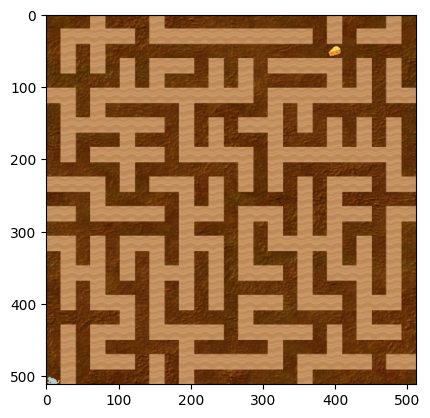

In [1]:
import matplotlib.pyplot as plt
from procgen_tools import maze
# Create a maze environment
venv = maze.create_venv(1, start_level=100, num_levels=1)
# Parse the environment state
env_state = maze.state_from_venv(venv, 0)
# Display state values
print(env_state.state_vals.keys())
# Show a rendering of the first
venv.reset()
render = venv.render(mode='rgb_array')
plt.imshow(render)
plt.show()

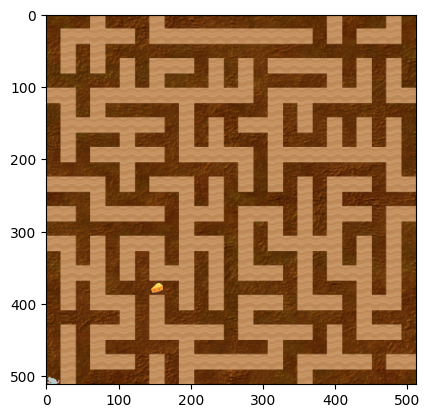

In [2]:
maze.move_cheese_in_state(env_state, (6,7))
venv.env.callmethod('set_state', [env_state.state_bytes])
venv.reset()
render = venv.render(mode='rgb_array')
plt.imshow(render)
plt.show()

Policy loaded successfully


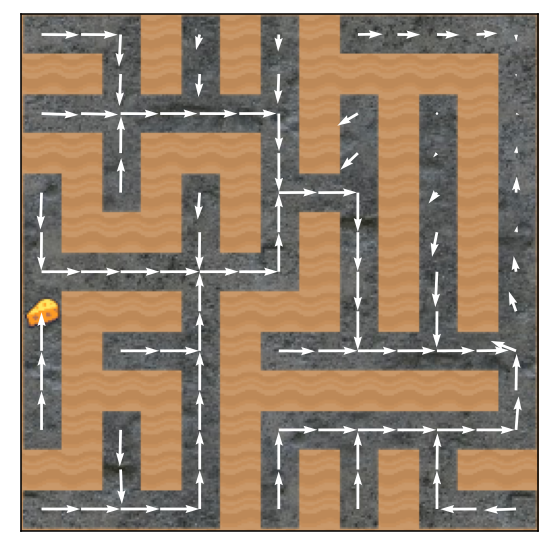

In [3]:
import torch as t
from procgen_tools import maze, vfield, models

policy = models.load_policy('../trained_models/maze_I/model_rand_region_1.pth', 15, t.device('cpu'))
print("Policy loaded successfully")

# Create and show a vector field
venv = maze.create_venv(1, start_level=0, num_levels=1)
vf_original = vfield.vector_field(venv, policy)
vfield.plot_vf(vf_original)
plt.show()

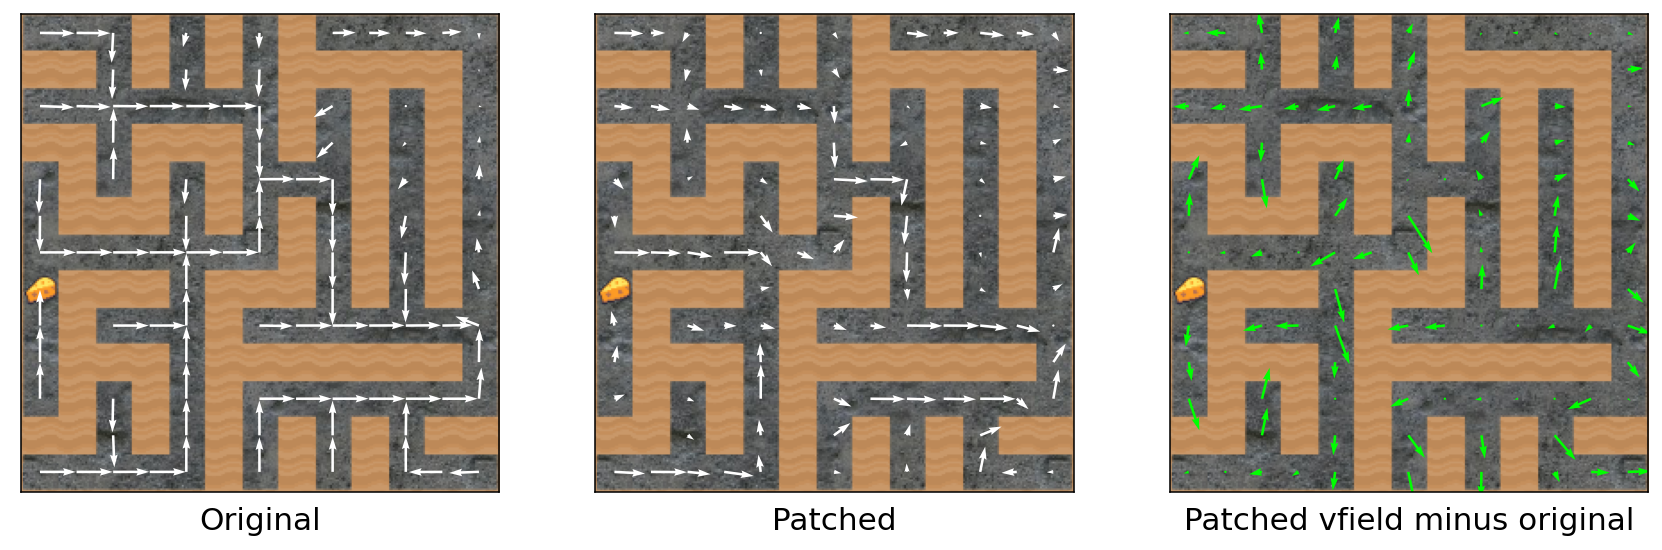

In [4]:
import circrl.module_hook as cmh
hook = cmh.ModuleHook(policy)
patches = {'embedder.block2.res1.resadd_out': lambda outp: outp + 0.2*t.randn_like(outp)}
venv = maze.create_venv(1, start_level=0, num_levels=1)
with hook.use_patches(patches):
    vf_patched = vfield.vector_field(venv, hook.network)
vfield.plot_vfs(vf_original, vf_patched)
plt.show()

# Feature Visualization
Seems like there is a library referenced in the Feature Visualization article by Chris Olah called Lucid. Unfortunately, Lucid only works for tensorflow version 1.x. Not only is that version of tensorflow vastly out of date, but the imported model we have uses Pytorch.

In [5]:
def layer_gradient(model, input_tensor):
	input_tensor.requires_grad = True
	output = model(input_tensor)[1] #.to(device)
	focus = output # the target to maximize the output
	target = t.ones(focus.shape)*200 # make a large target of the correct dims
	loss = t.sum(target - focus)
	loss.backward()
	gradient = input_tensor.grad
	return gradient


In [6]:
# Let's get some sort of interpretation for what our model looks like
from torchinfo import summary
print(render.shape)
#input_tens = t.unsqueeze(t.tensor(render).float().permute(2, 0, 1), 0)

# To be interpreted at a later date, all I know is that working through sending states through to the model
# via any method normal to be was not working.
venv = maze.create_venv(1, start_level=100, num_levels=1)
new_state = maze.copy_venv(venv, 0)
venv_all, (
        legal_mouse_positions,
        grid,) = maze.venv_with_all_mouse_positions(new_state)
batched_obs = t.tensor(
        venv_all.reset(), dtype=t.float32
)
print(batched_obs.shape)
summary(policy, input_data=batched_obs)

(512, 512, 3)
torch.Size([336, 3, 64, 64])


Layer (type:depth-idx)                             Output Shape              Param #
CategoricalPolicy                                  --                        --
├─InterpretableImpalaModel: 1-1                    [336, 256]                --
│    └─InterpretableImpalaBlock: 2-1               [336, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                            [336, 64, 64, 64]         1,792
│    │    └─MaxPool2d: 3-2                         [336, 64, 32, 32]         --
│    │    └─InterpretableResidualBlock: 3-3        [336, 64, 32, 32]         73,856
│    │    └─InterpretableResidualBlock: 3-4        [336, 64, 32, 32]         73,856
│    └─InterpretableImpalaBlock: 2-2               [336, 128, 16, 16]        --
│    │    └─Conv2d: 3-5                            [336, 128, 32, 32]        73,856
│    │    └─MaxPool2d: 3-6                         [336, 128, 16, 16]        --
│    │    └─InterpretableResidualBlock: 3-7        [336, 128, 16, 16]        295,168
│    │    └─Int

The above tells us what the model looks like. This lets us identify points of particular interest. 

# Visualizing Kernel Activations
The above block tells us that this model is quite deep, let's try visualizing some kernels just to see what the model is looking at

In [7]:
import numpy
from tqdm import tqdm

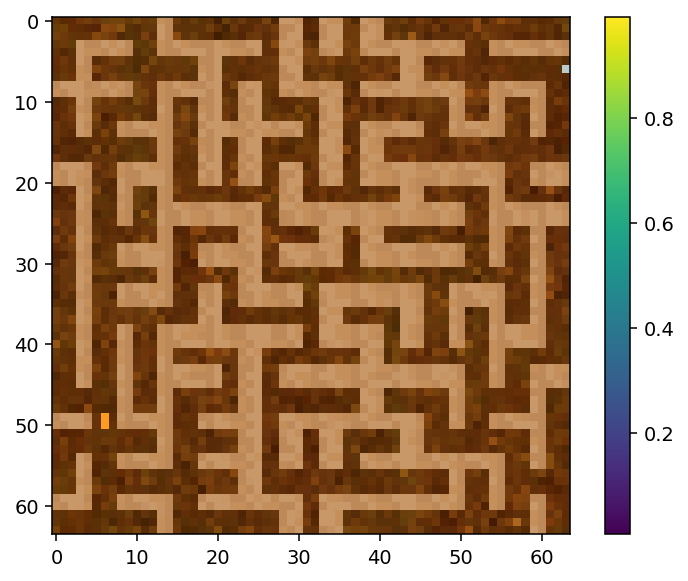

In [8]:
plt.imshow(batched_obs[1].numpy().T)
plt.colorbar()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 932.17it/s]


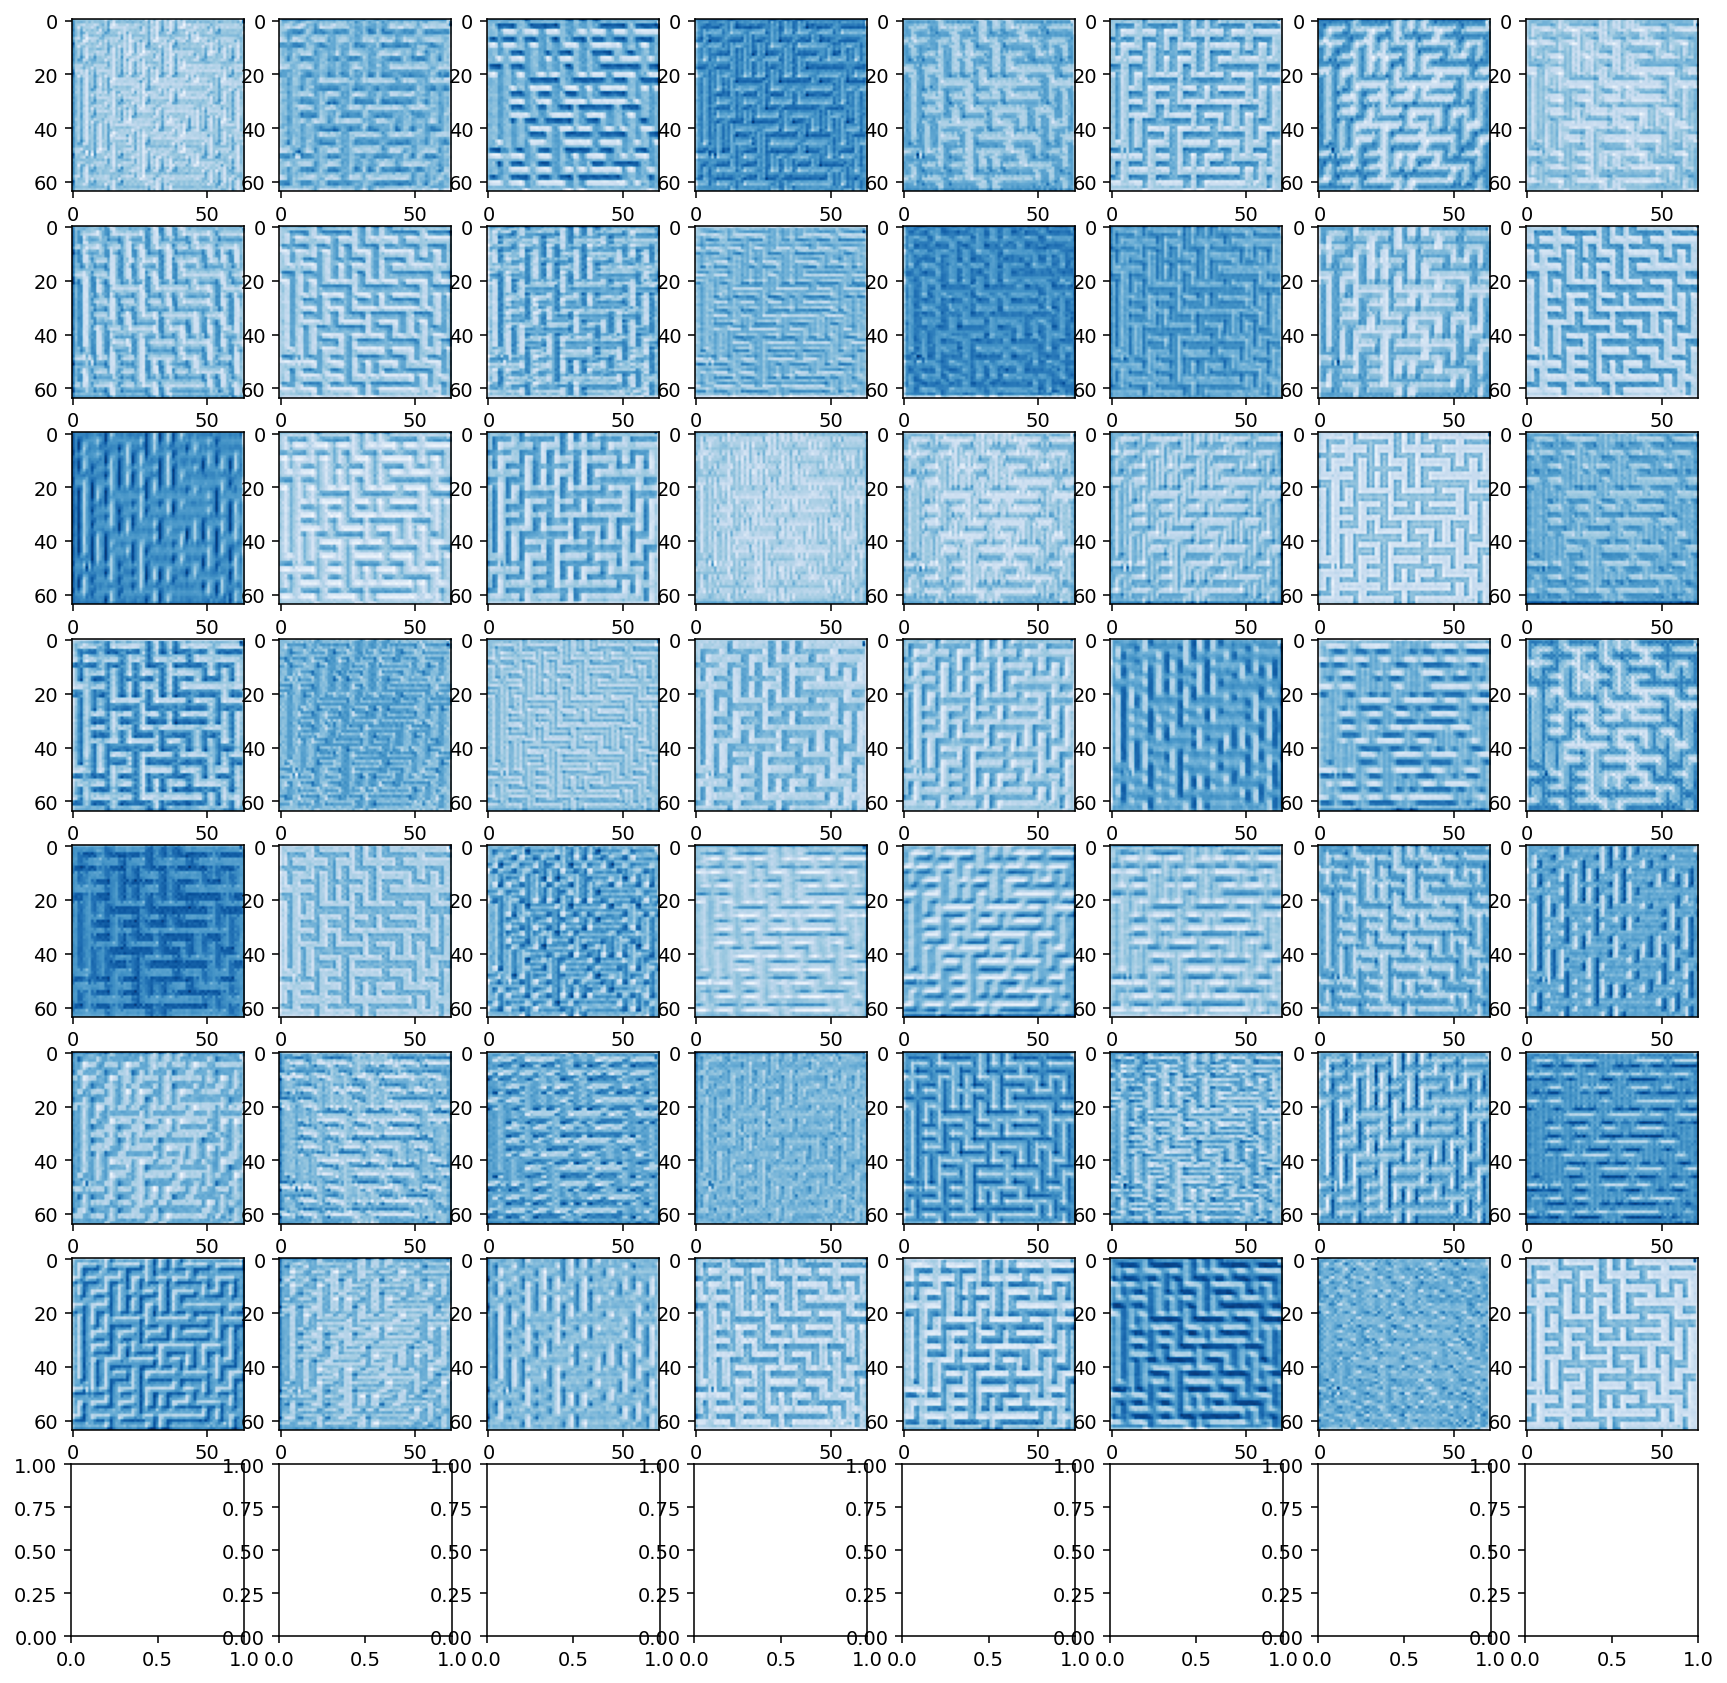

In [9]:
# Convolutional layer 3-1 in the graph above.
def hook_fn(m, i, o):
  visualisation[m] = o 
    
visualisation = {}
h2 = policy.embedder.block1.conv.register_forward_hook(hook_fn)
output = policy(batched_obs)
focus = 0.0
for v in visualisation.keys():
    focus = visualisation[v]
    break
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
for i in tqdm(range(focus[0].shape[0])):
    j = i
    c = 0
    while j - 8 >= 8:
        c += 1 
        j -= 8
    ax[c, i%8].imshow(focus[0, i, :, :].detach().numpy().T, cmap='Blues')

plt.show()
h2.remove()

1
torch.Size([336, 128, 32, 32])


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1469.24it/s]


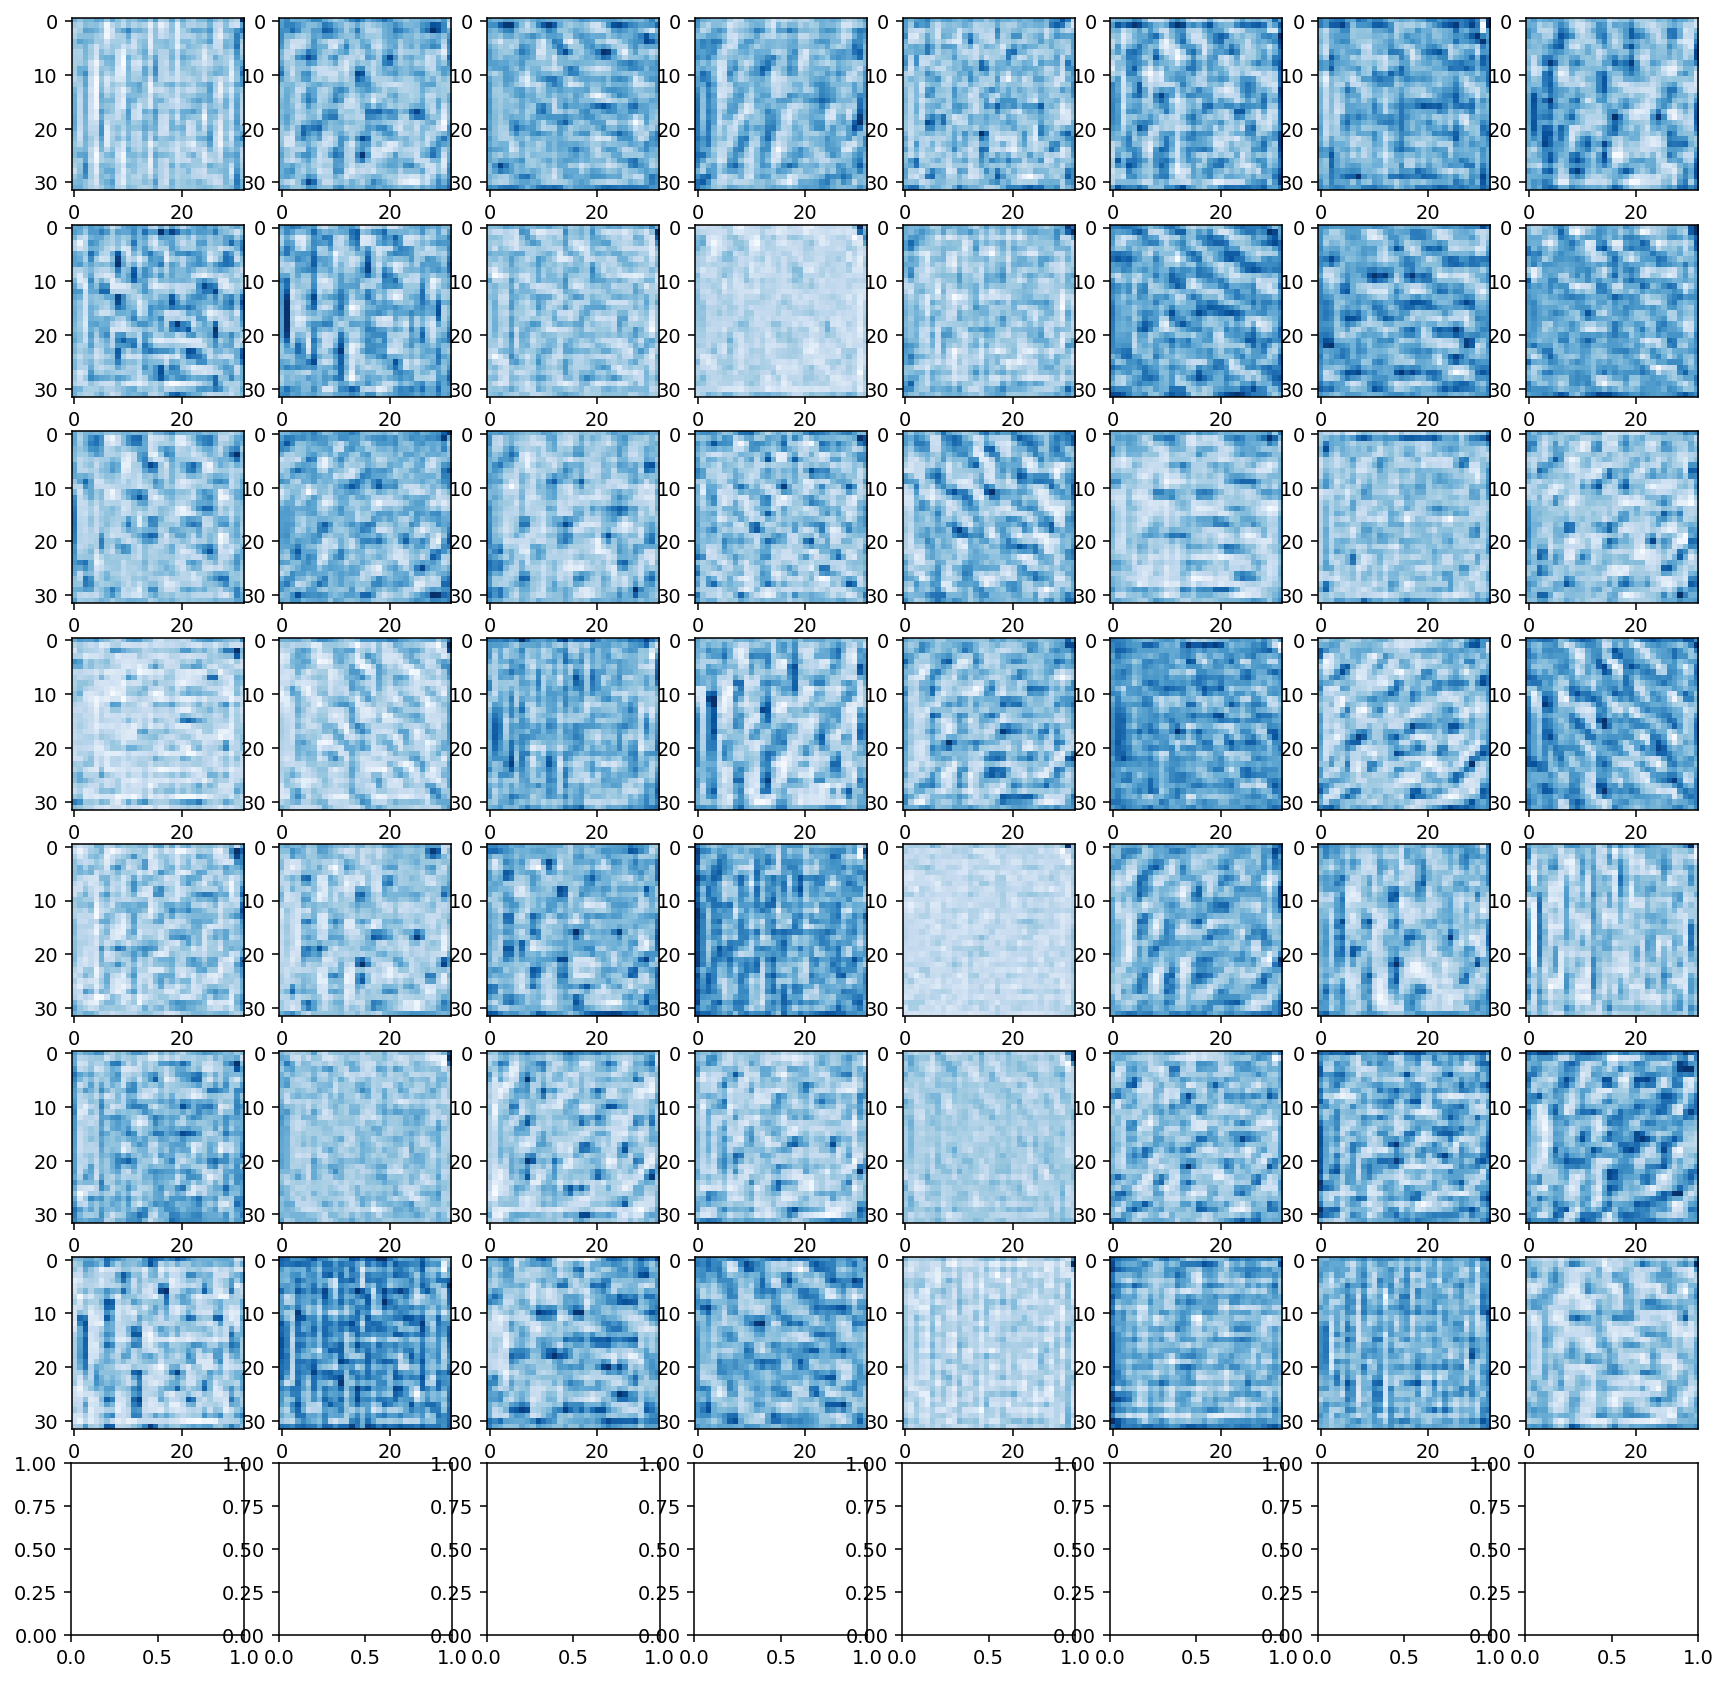

In [10]:
# Definitely catch some redundancies in the previous layer. What about the next one?
# Convolutional Layer 3-5 in the graph above
visualisation = {}
h3 = policy.embedder.block2.conv.register_forward_hook(hook_fn)
output = policy(batched_obs)
focus = 0.0

print(len(visualisation))
for v in visualisation.keys():
    print(visualisation[v].shape)
    focus = visualisation[v]
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
for i in tqdm(range(focus[0].shape[0]//2)):
    j = i
    c = 0
    while j - 8 >= 8:
        c += 1 
        j -= 8
    ax[c, i%8].imshow(focus[0, i, :, :].detach().numpy().T, cmap='Blues')

plt.show()
h3.remove()

1
torch.Size([336, 64, 32, 32])


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1581.84it/s]


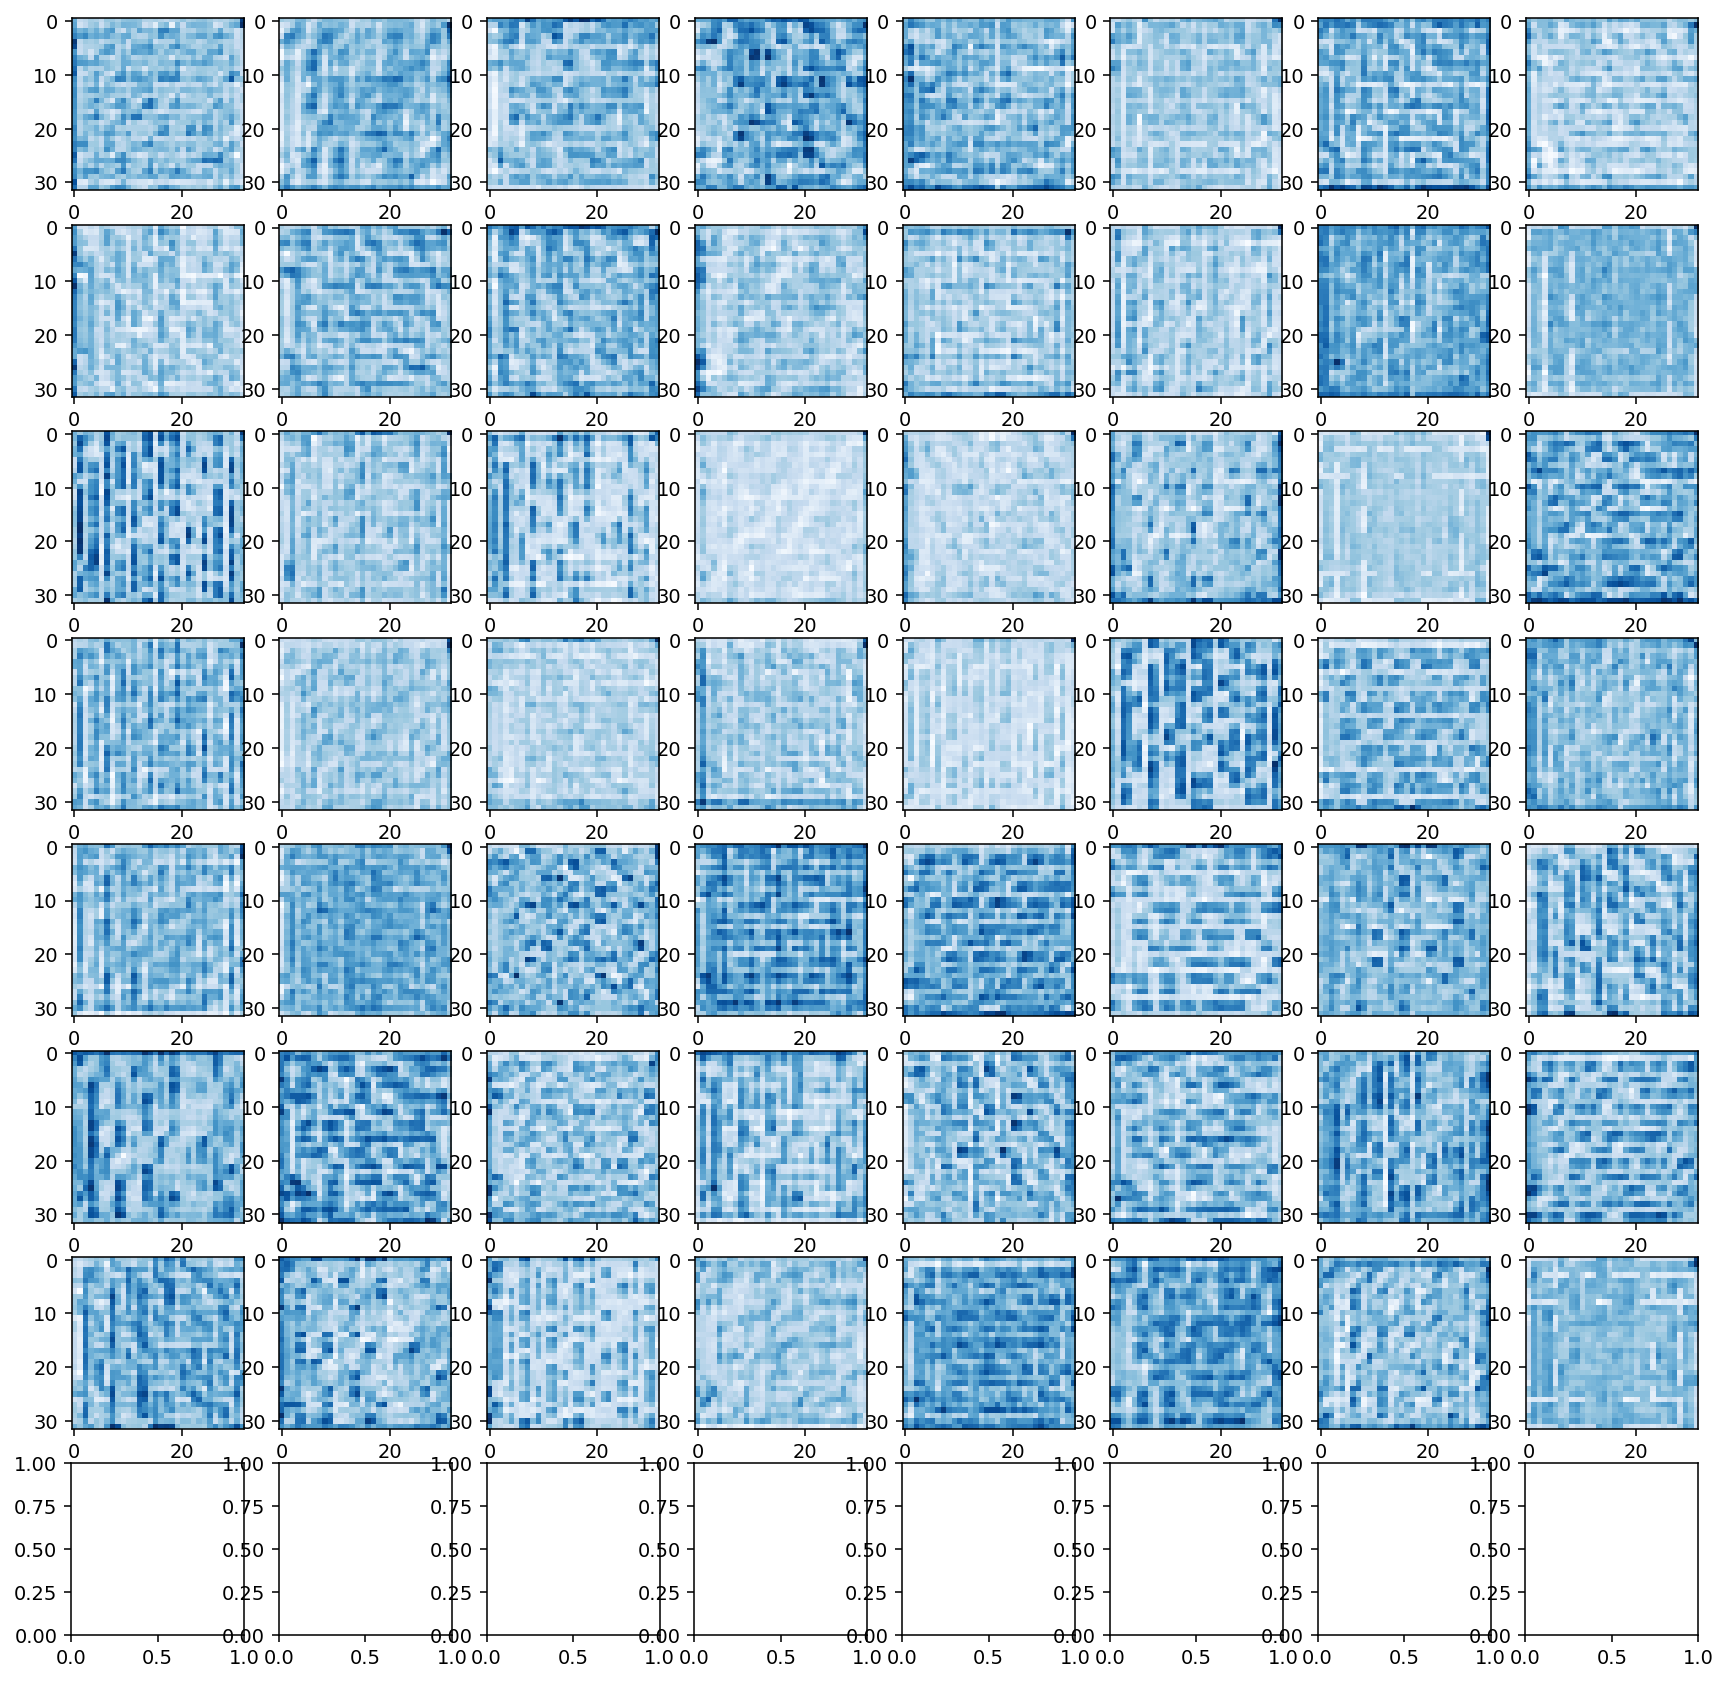

In [11]:
# Significantly less interpretable as it goes on, but I am curious to see what the "interpretable residual blocks" might look like
visualisation = {}
h3 = policy.embedder.block1.res1.resadd.register_forward_hook(hook_fn)
output = policy(batched_obs)
focus = 0.0

print(len(visualisation))
for v in visualisation.keys():
    print(visualisation[v].shape)
    focus = visualisation[v]
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
for i in tqdm(range(focus[0].shape[0])):
    j = i
    c = 0
    while j - 8 >= 8:
        c += 1 
        j -= 8
    ax[c, i%8].imshow(focus[0, i, :, :].detach().numpy().T, cmap='Blues')

plt.show()
h3.remove()

1
torch.Size([336, 128, 16, 16])


 56%|█████████████████████████████████████████████                                   | 72/128 [00:00<00:00, 1075.74it/s]


IndexError: index 8 is out of bounds for axis 0 with size 8

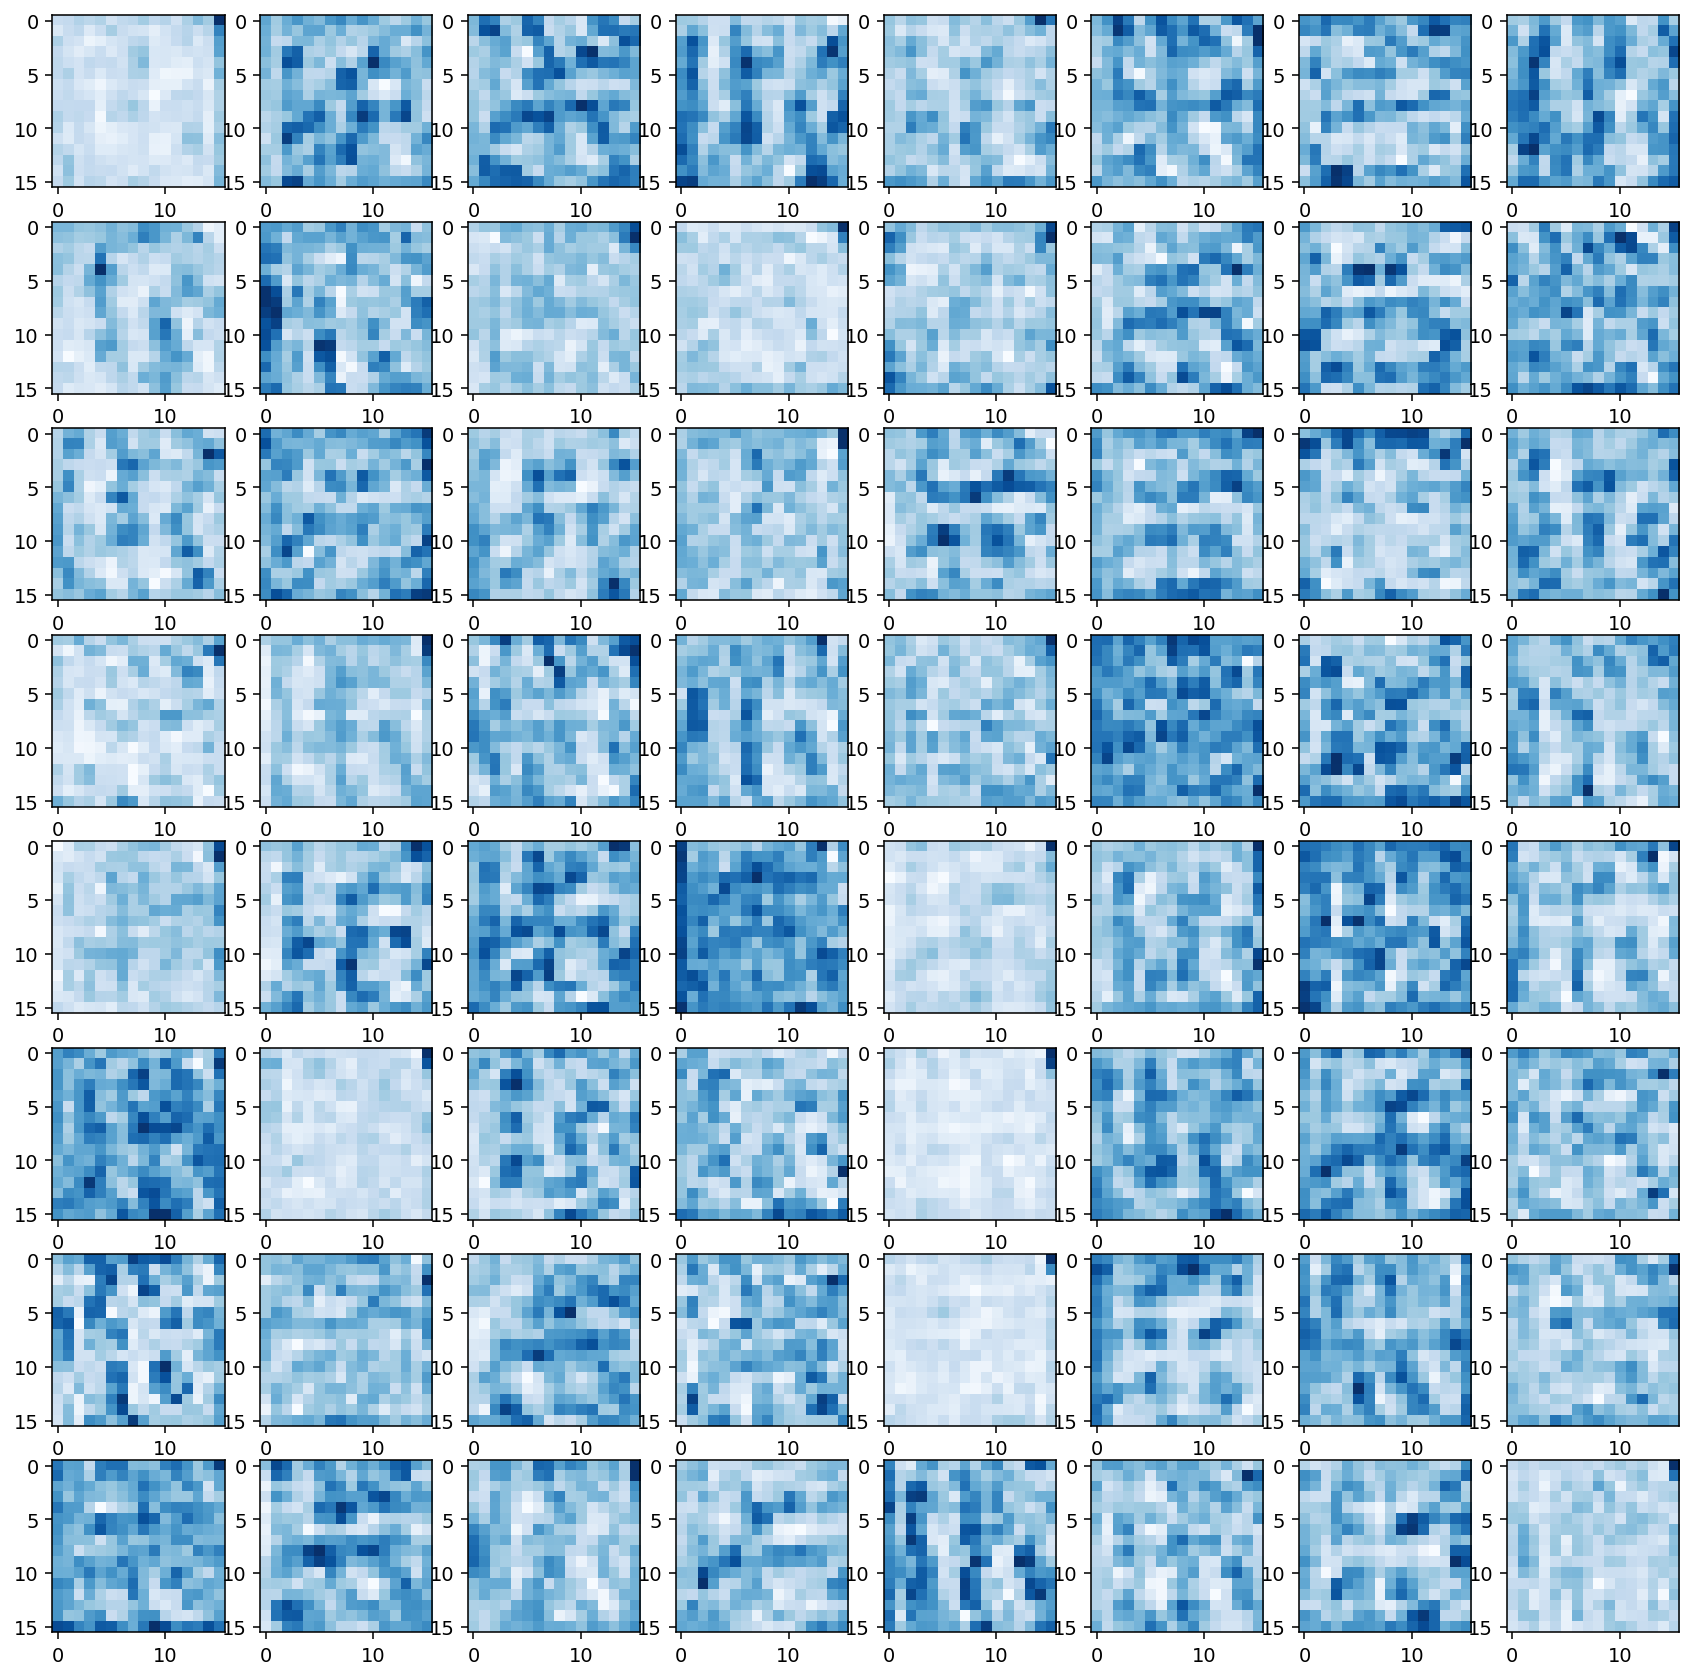

In [12]:
# Significantly less interpretable as it goes on, but I am curious to see what the "interpretable residual blocks" might look like
visualisation = {}
h4 = policy.embedder.block2.res1.resadd.register_forward_hook(hook_fn)
output = policy(batched_obs)
focus = 0.0

print(len(visualisation))
for v in visualisation.keys():
    print(visualisation[v].shape)
    focus = visualisation[v]
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
for i in tqdm(range(focus[0].shape[0])):
    j = i
    c = 0
    while j - 8 >= 8:
        c += 1 
        j -= 8
    ax[c, i%8].imshow(focus[0, i, :, :].detach().numpy().T, cmap='Blues')

plt.show()
h4.remove()

In [ ]:
visualisation = {}

#def get_all_layers(net):
#  for name, layer in policy._modules.items():
#    #If it is a sequential, don't register a hook on it
#    # but recursively register hook on all it's module children
#    if isinstance(layer, t.nn.Sequential):
#      get_all_layers(layer)
#    else:
#      # it's a non sequential. Register a hook
#      layer.register_forward_hook(hook_fn)

In [109]:
import numpy as np
from perlin_noise import PerlinNoise
noise = PerlinNoise(octaves=8, seed=1)
chan, xpix, ypix = 3, 64, 64
perl = np.array([[[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)] for _ in range(chan)])
new_input = t.tensor(perl, requires_grad=True, dtype=t.float32).unsqueeze(axis=0)
print(new_input.shape)
  
out = policy(new_input)
print("Output: ", out)

torch.Size([1, 3, 64, 64])
Output:  (Categorical(logits: torch.Size([1, 15])), tensor([5.0252], grad_fn=<ReshapeAliasBackward0>))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


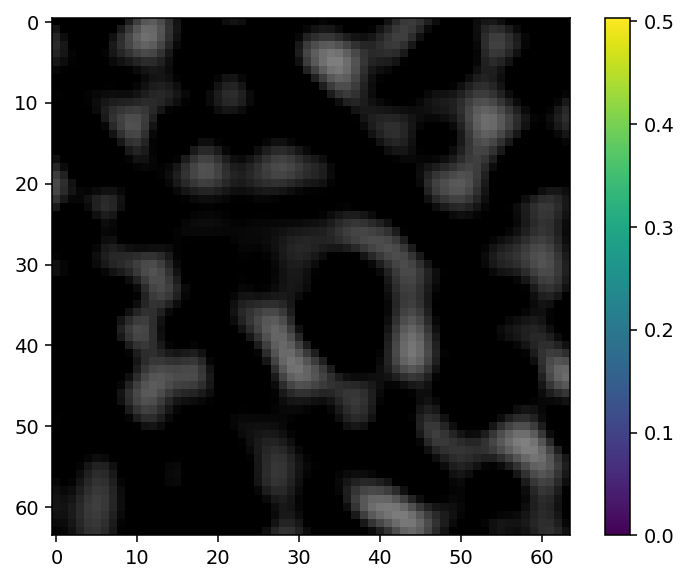

tensor([[[[ 0.0000,  0.0838,  0.1465,  ...,  0.0667,  0.0396,  0.0149],
          [-0.1028, -0.0171,  0.0537,  ...,  0.0659,  0.0463,  0.0255],
          [-0.2347, -0.1452, -0.0627,  ...,  0.1021,  0.0880,  0.0706],
          ...,
          [-0.0739, -0.0744, -0.1107,  ...,  0.1509,  0.1731,  0.1900],
          [-0.0259, -0.0513, -0.1082,  ...,  0.0864,  0.1196,  0.1518],
          [ 0.0014, -0.0362, -0.1006,  ..., -0.0085,  0.0309,  0.0711]],

         [[ 0.0000,  0.0838,  0.1465,  ...,  0.0667,  0.0396,  0.0149],
          [-0.1028, -0.0171,  0.0537,  ...,  0.0659,  0.0463,  0.0255],
          [-0.2347, -0.1452, -0.0627,  ...,  0.1021,  0.0880,  0.0706],
          ...,
          [-0.0739, -0.0744, -0.1107,  ...,  0.1509,  0.1731,  0.1900],
          [-0.0259, -0.0513, -0.1082,  ...,  0.0864,  0.1196,  0.1518],
          [ 0.0014, -0.0362, -0.1006,  ..., -0.0085,  0.0309,  0.0711]],

         [[ 0.0000,  0.0838,  0.1465,  ...,  0.0667,  0.0396,  0.0149],
          [-0.1028, -0.0171,  

In [110]:
old_input = new_input.clone()
neuron_of_interest = 4
plt.imshow(new_input.squeeze(axis=0).detach().numpy().T)
plt.colorbar()
plt.show()
print(new_input)

In [113]:
epochs = 100
lr = 1
losses = []
avg_activation = []
for e in tqdm(range(epochs)):
    visualisation = {}
    h5 = policy.embedder.block2.res1.resadd.register_forward_hook(hook_fn)
    focus = 0.0
    new_input.retain_grad()
    output = policy(new_input)
    #print(output)
    #print(len(visualisation))
    for i, v in enumerate(visualisation.keys()):
        #print(visualisation[v].shape)
        if i == 0:
            focus = visualisation[v]

    target = t.ones(focus[0, :, :, :].shape) # make a large target of the correct dims
    loss = t.mean(t.sqrt(t.square(focus[0, :, :, :] - target)))

    # Grab losses and avg_activation
    losses.append(loss.detach().numpy())
    #print(focus[0, :, :, :])
    avg_activation.append(t.sum(focus[0, :, :, :].detach()).numpy())
    
    loss.backward()
    gradient = new_input.grad
    with t.no_grad():
       new_input -= lr*gradient
    h5.remove()
    
  

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.22it/s]


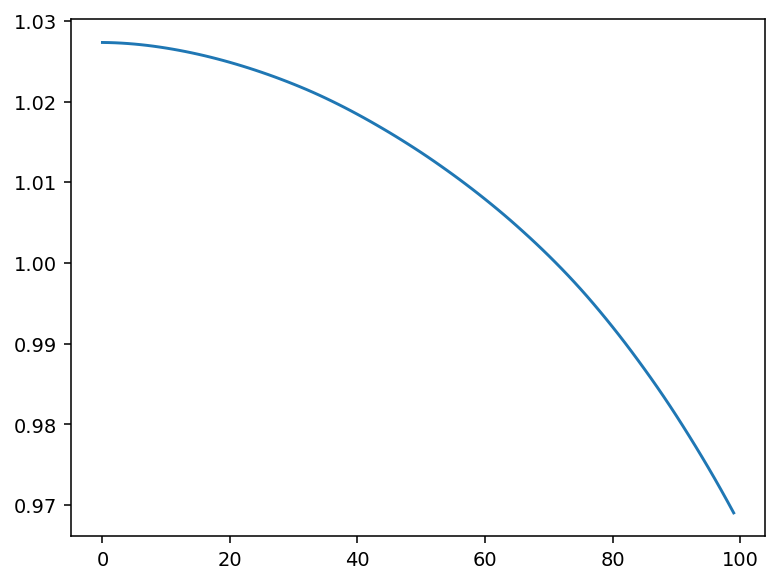

In [114]:
plt.plot(losses)
plt.show()

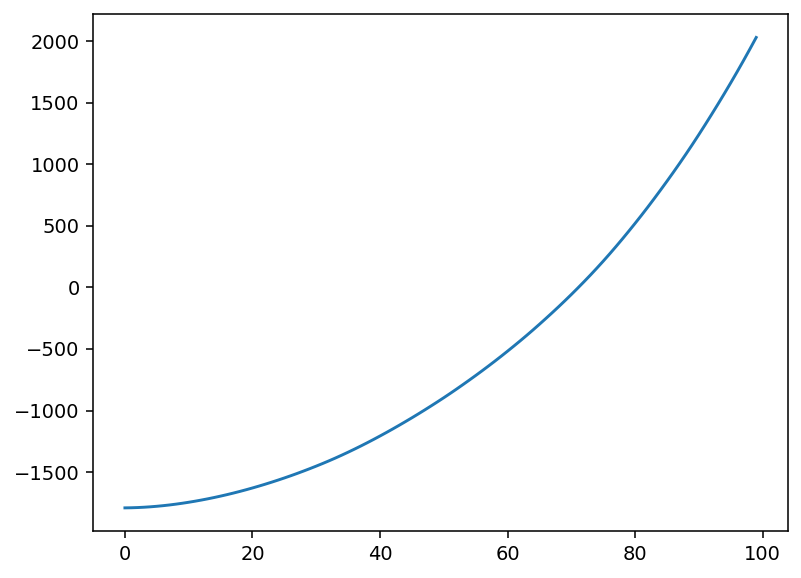

In [115]:
plt.plot(avg_activation)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


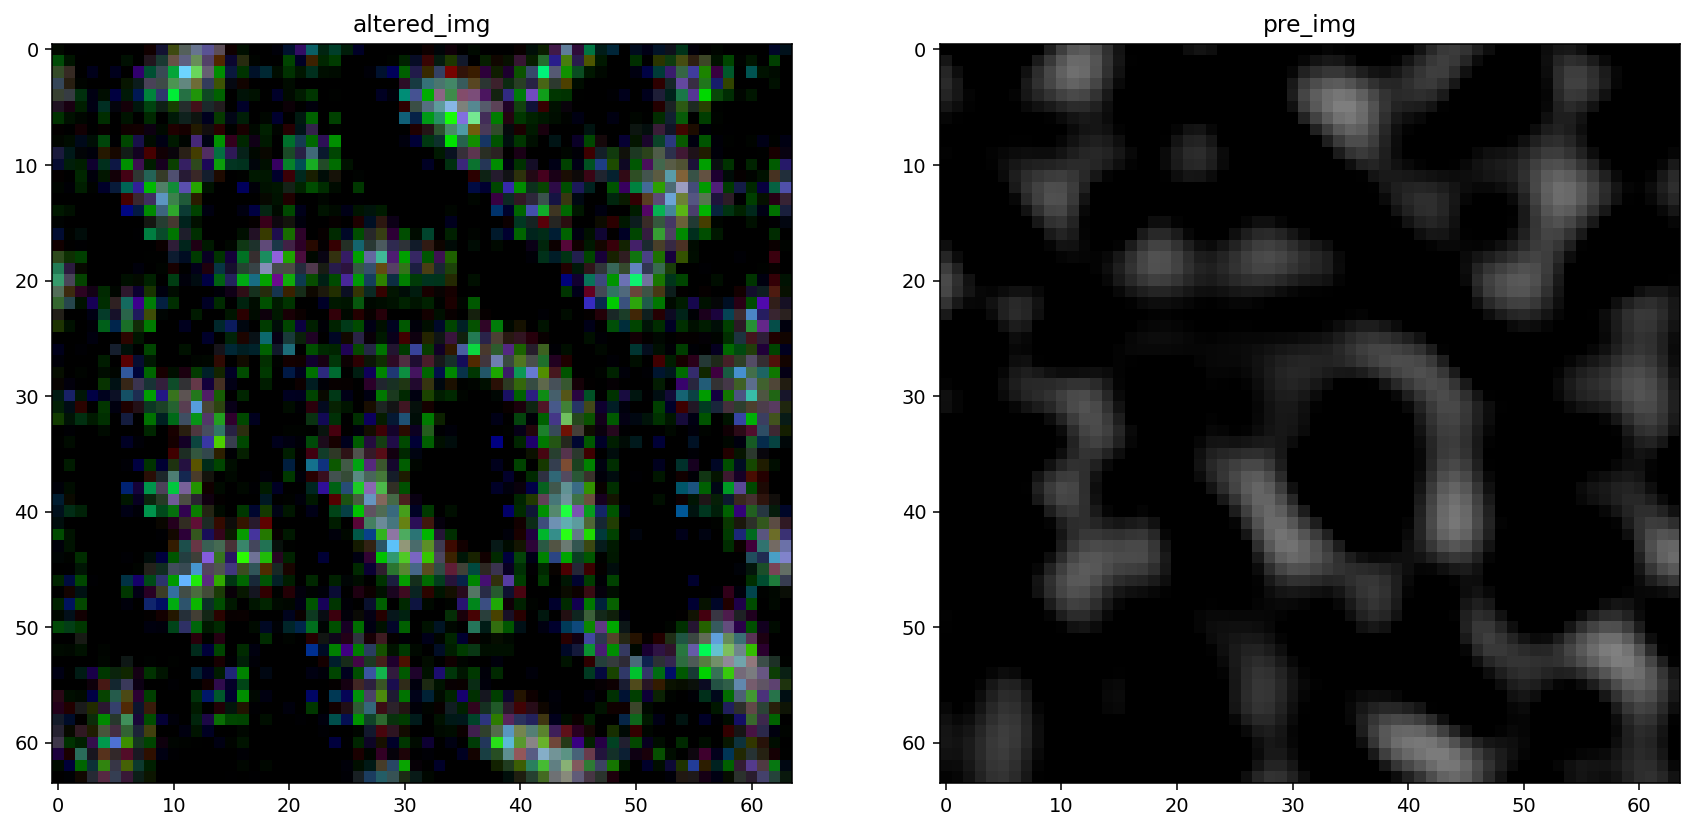

In [116]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(t.squeeze(new_input[0].detach(), axis=0).numpy().T)
axs[0].title.set_text('altered_img')
axs[1].imshow(t.squeeze(old_input[0].detach(), axis=0).numpy().T)
axs[1].title.set_text('pre_img')

# not entirely sure how to make this not suck, so maybe worth reading lucids tutorial for more info?

In [14]:
shown_input = t.squeeze(new_input.detach(), axis=0).numpy().T
shown_input

array([[[-0.04693469, -1.3393117 ,  0.38857573],
        [ 0.33252496, -0.35425785, -0.6925113 ],
        [ 0.44382733,  0.29064953,  1.3602383 ],
        ...,
        [ 0.77061135, -0.04980424,  0.12557884],
        [-1.3166419 , -0.7634777 , -0.01326998],
        [ 0.20279646,  0.9564471 ,  0.4427818 ]],

       [[-0.24411453,  0.6386087 ,  0.56911016],
        [-0.9939032 , -1.5585757 , -1.0664967 ],
        [-1.3410568 , -1.2180326 ,  0.42623398],
        ...,
        [-0.9181354 , -0.8597785 , -1.1560715 ],
        [-0.5913185 ,  1.3041756 ,  0.1719173 ],
        [-2.3992193 ,  2.1239913 , -0.25853613]],

       [[ 2.1650903 , -0.919804  , -1.5926121 ],
        [ 0.01262701, -0.36055467,  0.08368417],
        [-1.2325063 , -1.2270172 , -0.67894703],
        ...,
        [ 0.35552266,  0.1369264 , -0.6324918 ],
        [ 1.3332448 , -2.1812015 ,  0.521238  ],
        [ 0.6943377 ,  1.0390545 , -0.8302173 ]],

       ...,

       [[ 4.536526  ,  0.5741316 ,  2.9864957 ],
        [-3

In [102]:
def new_layer_gradient(model, input_tensor):
    visualisation = {}
    #h2 = model.embedder.block1.conv.register_forward_hook(hook_fn)
    input_tensor.requires_grad = True
    output = policy(new_input)
    print(visualisation.keys())
    #focus = visualisation["Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))"]
    target = t.ones(focus.shape)*200 # make a large target of the correct dims
    loss = t.sum(target - focus)
    loss.backward()
    gradient = input_tensor.grad
    h2.remove()
    return gradient
